In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

def readFile(filename):

    data = {"ch0": [], "ch1": [], "ch3": []}

    with open(filename) as file:

        # skip file header
        file.readline()
        file.readline()
        file.readline()
        file.readline()

        while True:

            # skip event header and check end of file
            if not file.readline(): break
            file.readline()

            # skip channel 0 header
            file.readline()

            ch0_vals = file.readline()
            ch0_vals = list(map(lambda x: -float(x), ch0_vals.split()))
            data["ch0"].append(np.array(ch0_vals))

            # skip channel 1 header
            file.readline()

            ch1_vals = file.readline()
            ch1_vals = list(map(lambda x: -float(x), ch1_vals.split()))
            data["ch1"].append(np.array(ch1_vals))

            # skip channel 2 header
            file.readline()

            ch3_vals = file.readline()
            ch3_vals = list(map(lambda x: -float(x), ch3_vals.split()))
            data["ch3"].append(np.array(ch3_vals))

    data["ch0"] = np.array(data["ch0"])
    data["ch1"] = np.array(data["ch1"])
    data["ch3"] = np.array(data["ch3"])

    return data

##  ################  ################  ################
##  Slow wave catcher
##  ################  ################  ################
data_slow = readFile("Data_received/New_measurements/Plate/Run_WFs_PMT+plate_100 mks_10K evts_4_1_2025_Ascii.dat")

SAMPLE_RATE_SLOW = 100
times_slow = np.arange(1024)*SAMPLE_RATE_SLOW

data_slow["times"] = times_slow
data_slow["sample_rate"] = SAMPLE_RATE_SLOW
data_slow["type"] = "slow"


##  ################  ################  ################
##  Fast wave catcher
##  ################  ################  ################
data_fast = readFile("Data_received/New_measurements/Plate/Run_WFs_PMT+plate_2.5 mks_10K evts_4_1_2025_Ascii.dat")

SAMPLE_RATE_FAST = 2.5
times_fast = np.arange(1024)*SAMPLE_RATE_FAST

data_fast["times"] = times_fast
data_fast["sample_rate"] = SAMPLE_RATE_FAST
data_fast["type"] = "fast"

In [3]:
def align_datasamples(data):

    # start index
    data["st_idx"] = np.empty(data["ch0"].shape[0], dtype=int)

    for i in range(data["ch0"].shape[0]):

        max_val = np.max(data["ch0"][i])

        start_idx = np.argmax(data["ch0"][i] >= 0.5*max_val)

        if data["type"] == "fast":
            # remove bad events. ch0 max value is about 0.8 for all good events.
            if np.max(data["ch0"][i]) < 0.6:
                start_idx = 0

        elif data["type"] == "slow":
            # sometimes we have two synchro peacks, the correct one is first and low in y scale
            # this if branch of code to account for that effect
            if start_idx > 100:
                
                start_idx = np.argmax(data["ch0"][i] >= 0.03)

        else:
            print("ERROR: unknown wave catcher type")

        data["st_idx"][i] = start_idx

    min_st_idx = int(np.min(data["st_idx"]))
    max_st_idx = int(np.max(data["st_idx"]))

    data["min_st_idx"] = min_st_idx
    data["max_st_idx"] = max_st_idx

    data_shifted = dict(data)
    data_shifted["ch0"] = np.empty([ data["ch0"].shape[0], data["ch0"].shape[1] - (max_st_idx-min_st_idx) ])
    data_shifted["ch1"] = np.empty([ data["ch1"].shape[0], data["ch1"].shape[1] - (max_st_idx-min_st_idx) ])
    data_shifted["ch3"] = np.empty([ data["ch3"].shape[0], data["ch3"].shape[1] - (max_st_idx-min_st_idx) ])


    for i in range(data["ch0"].shape[0]):

        stIdx = data["st_idx"][i]

        start_idx = stIdx-min_st_idx
        stop_ind  = data["ch0"][i].size -(max_st_idx-stIdx)

        data_shifted["ch0"][i] = data["ch0"][i, start_idx: stop_ind]
        data_shifted["ch1"][i] = data["ch1"][i, start_idx: stop_ind]
        data_shifted["ch3"][i] = data["ch3"][i, start_idx: stop_ind]

    data_shifted["times"] = data["times"][:-(max_st_idx-min_st_idx)]

    return data_shifted

data_fast_aligned = align_datasamples(data_fast)
data_slow_aligned = align_datasamples(data_slow)

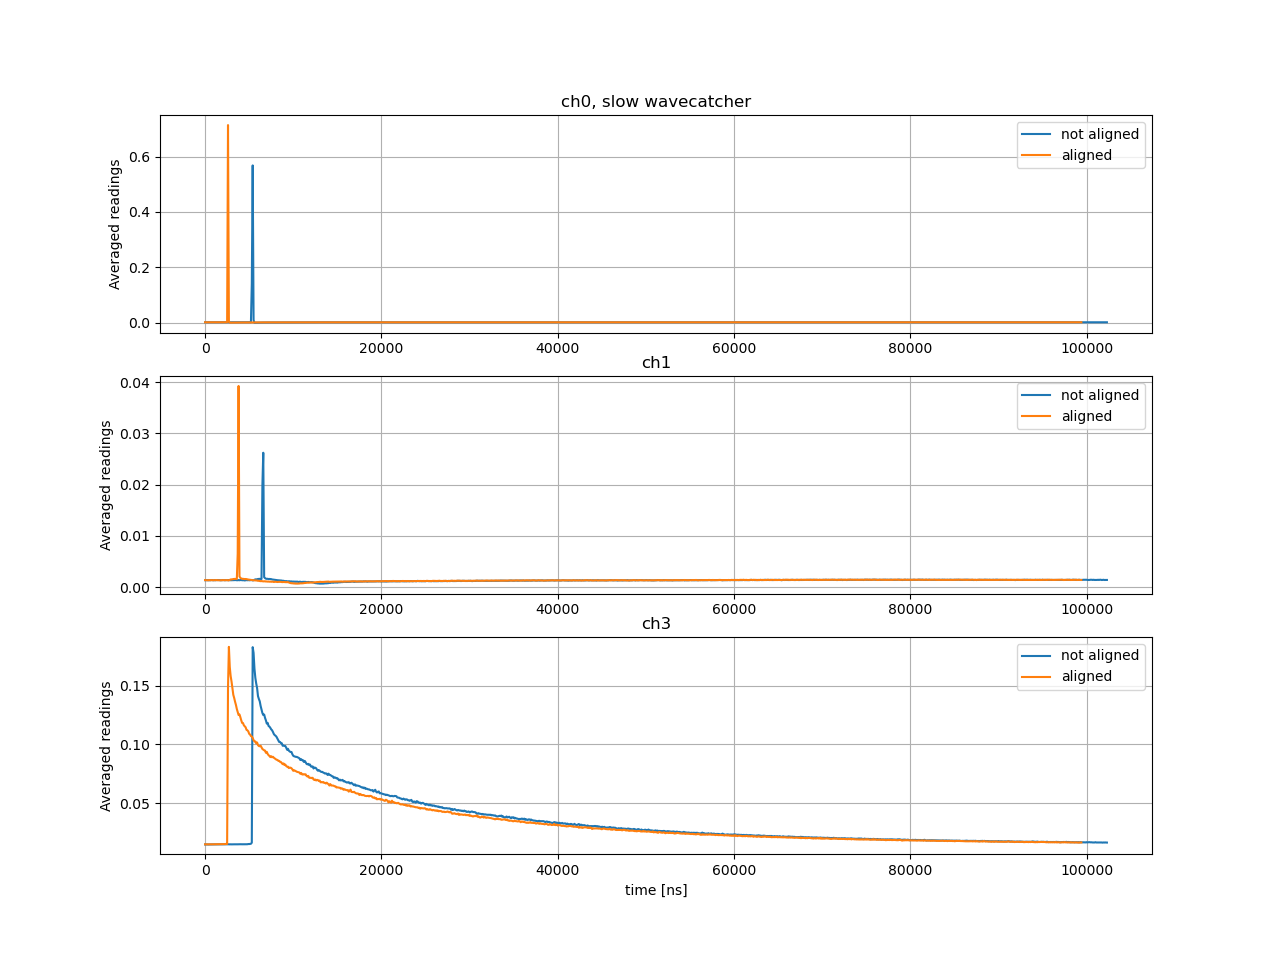

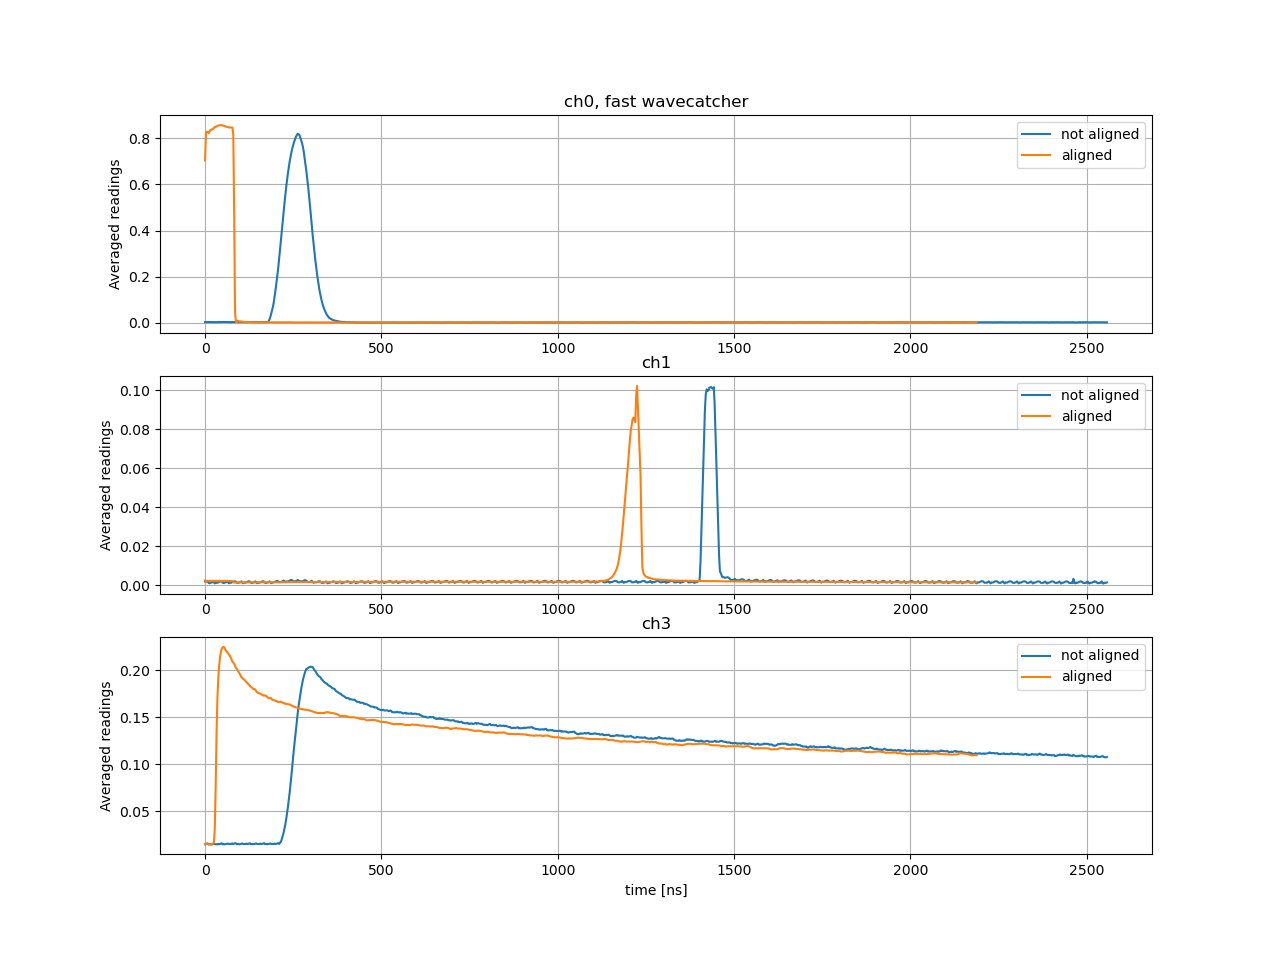

In [4]:
def visualise_aligning(data_raw, data_aligned):

    plt.figure(figsize=(6.4*2, 4.8*2))

    assert data_raw["type"] == data_aligned["type"]


    plt.subplot(3,1,1)
    plt.plot(data_raw["times"], np.mean(data_raw["ch0"], axis=0), label="not aligned")
    plt.plot(data_aligned["times"], np.mean(data_aligned["ch0"], axis=0), label="aligned")
    plt.title(f"ch0, {data_raw['type']} wavecatcher")
    plt.legend()
    plt.grid()
    plt.ylabel("Averaged readings")

    plt.subplot(3,1,2)
    plt.plot(data_raw["times"], np.mean(data_raw["ch1"], axis=0), label="not aligned")
    plt.plot(data_aligned["times"], np.mean(data_aligned["ch1"], axis=0), label="aligned")
    plt.title("ch1")
    plt.legend()
    plt.grid()
    plt.ylabel("Averaged readings")

    plt.subplot(3,1,3)
    plt.plot(data_raw["times"], np.mean(data_raw["ch3"], axis=0), label="not aligned")
    plt.plot(data_aligned["times"], np.mean(data_aligned["ch3"], axis=0), label="aligned")
    plt.title("ch3")
    plt.legend()
    plt.grid()
    plt.ylabel("Averaged readings")

    plt.xlabel("time [ns]")



visualise_aligning(data_slow, data_slow_aligned)
visualise_aligning(data_fast, data_fast_aligned)

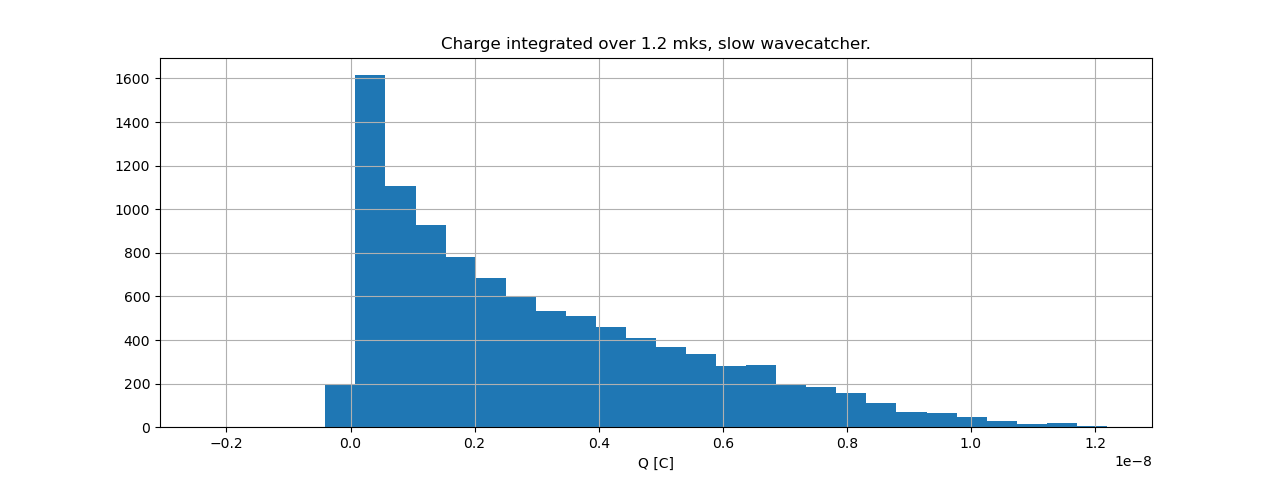

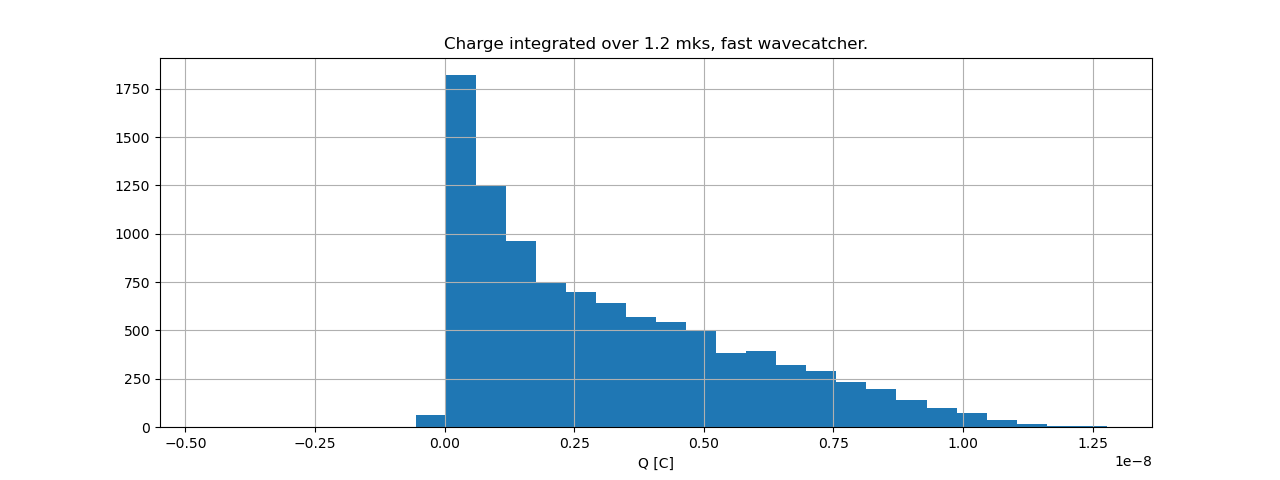

In [5]:
def calc_charge(data):

    if data["type"] == "fast":
        resistance = 50 # ohm
        st_idx = int(np.floor(22/data["sample_rate"]))
        md_idx = st_idx + int(np.floor(90/data["sample_rate"]))
        ed_idx = st_idx + int(np.floor(1200/data["sample_rate"]))
    elif data["type"] == "slow":
        resistance = 50 # ohm
        st_idx = int(np.floor(2500/data["sample_rate"]))
        md_idx = st_idx + int(np.floor(200/data["sample_rate"]))
        ed_idx = st_idx + int(np.floor(1200/data["sample_rate"]))        
    else:
        print("ERROR: unknown type of the wave catcher")


    data["Qc_arr"] = np.empty(data["ch3"].shape[0])
    data["Qs_arr"] = np.empty(data["ch3"].shape[0])

    for i in range(data["ch3"].shape[0]):

        bkg = np.mean(data["ch3"][i, :st_idx])

        Qc = (data["ch3"][i, st_idx:md_idx] - bkg)/resistance 
        Qc = np.sum(Qc)*data["sample_rate"]*1e-9
        data["Qc_arr"][i] = Qc

        Qs = (data["ch3"][i, md_idx:ed_idx] - bkg)/resistance
        Qs = np.sum(Qs)*data["sample_rate"]*1e-9
        data["Qs_arr"][i] = Qs
        

    plt.figure(figsize=(6.4*2, 4.8))
    plt.hist(data["Qc_arr"]+data["Qs_arr"], bins=30)
    plt.title(f"Charge integrated over 1.2 mks, {data['type']} wavecatcher.")
    plt.xlabel("Q [C]")
    plt.grid()

    
calc_charge(data_slow_aligned)
calc_charge(data_fast_aligned)

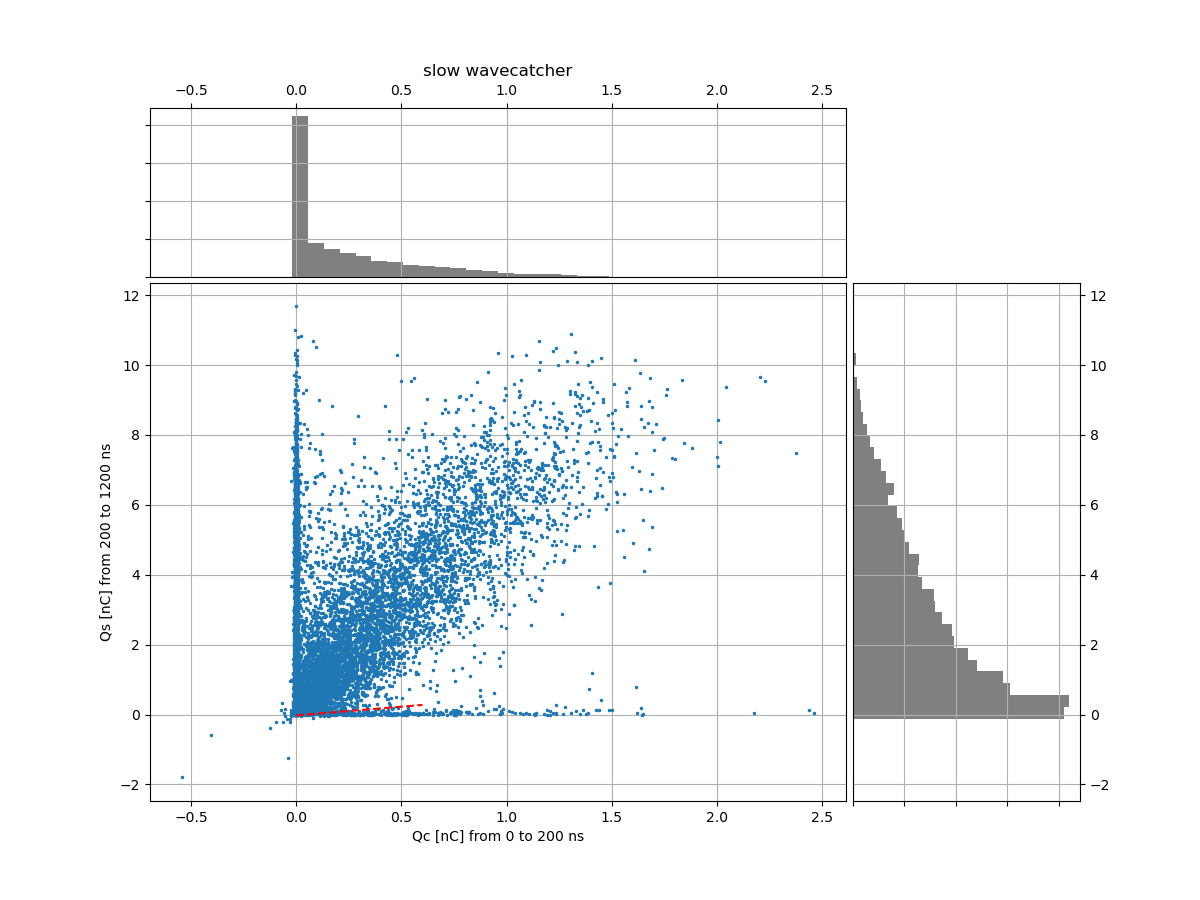

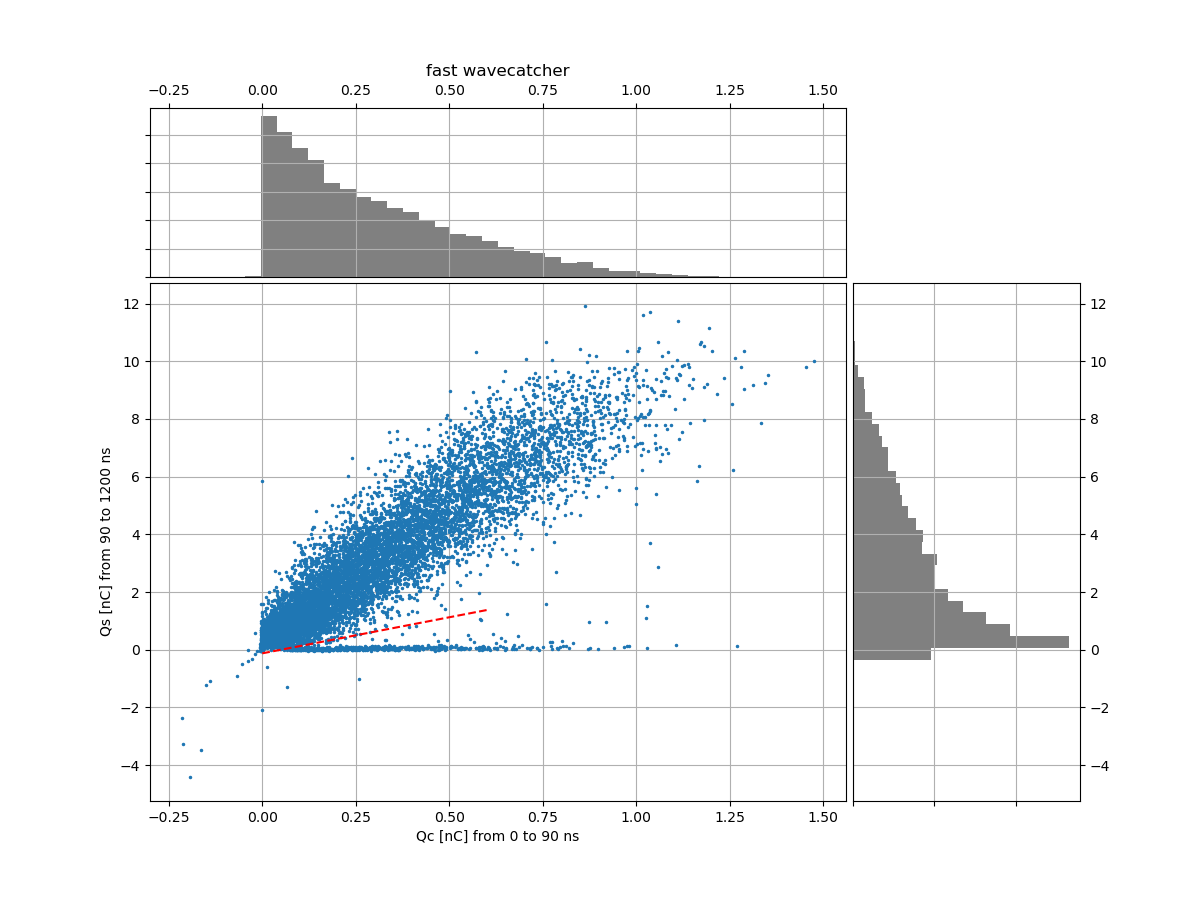

In [6]:
def visualise_charges(data):

    # Set up the axes with gridspec
    fig = plt.figure(figsize=(12, 9))
    grid = plt.GridSpec(4, 4, hspace=0.03, wspace=0.03)
    main_ax = fig.add_subplot(grid[1:, :-1])
    y_hist = fig.add_subplot(grid[1:, -1], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[0, :-1], yticklabels=[], sharex=main_ax)
    
    # scatter points on the main axes
    main_ax.plot(data["Qc_arr"]/1e-9, data["Qs_arr"]/1e-9, ".", markersize=3,)

    if data["type"] == "fast":
        main_ax.set_xlabel("Qc [nC] from 0 to 90 ns")
        main_ax.set_ylabel("Qs [nC] from 90 to 1200 ns")         
    elif data["type"] == "slow":
        main_ax.set_xlabel("Qc [nC] from 0 to 200 ns")
        main_ax.set_ylabel("Qs [nC] from 200 to 1200 ns")           
    else:
        print("ERROR: unknown type of the wave catcher")

    main_ax.grid()


    # histogram on the attached axes
    x_hist.hist(data["Qc_arr"]/1e-9, 40, histtype='stepfilled',
            orientation='vertical', color='gray')
    x_hist.xaxis.set_label_position('top')
    x_hist.xaxis.tick_top()
    x_hist.grid()
    x_hist.set_title(f"{data['type']} wavecatcher")


    y_hist.hist(data["Qs_arr"]/1e-9, 40, histtype='stepfilled',
            orientation='horizontal', color='gray')
    y_hist.yaxis.set_label_position('right')
    y_hist.yaxis.tick_right()
    y_hist.grid()


    if data["type"] == "fast":
        discrimination_curve = lambda x: 2.5*(x-0.05)   
        data["discrimination_curve"] = discrimination_curve      
    elif data["type"] == "slow":
        discrimination_curve = lambda x: 0.50*(x-0.05)     
        data["discrimination_curve"] = discrimination_curve     
    else:
        print("ERROR: unknown type of the wave catcher")

    
    disc_x_c = np.array([0, 0.6])
    disc_y_c = discrimination_curve(disc_x_c)
    main_ax.plot(disc_x_c, disc_y_c, "--r")    

visualise_charges(data_slow_aligned)
visualise_charges(data_fast_aligned)

In [7]:
def strip_cherencov_calc_average(data):

    acceptedEvents = data["Qs_arr"]/1e-9 > data['discrimination_curve'](data["Qc_arr"]/1e-9)

    data["ch3_average"] = np.mean(data["ch3"][acceptedEvents], axis=0)


strip_cherencov_calc_average(data_slow_aligned)
strip_cherencov_calc_average(data_fast_aligned)    

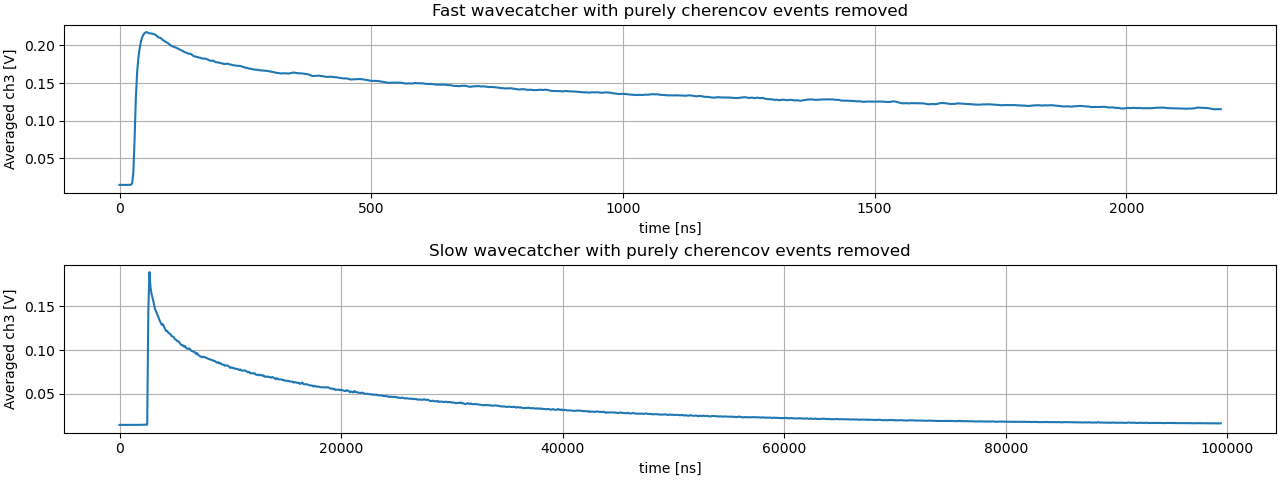

In [8]:
plt.figure(figsize=(6.4*2, 4.8), constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(data_fast_aligned["times"], data_fast_aligned["ch3_average"])
plt.ylabel("Averaged ch3 [V]")
plt.xlabel("time [ns]")
plt.title("Fast wavecatcher with purely cherencov events removed")
plt.grid()


plt.subplot(2,1,2)
plt.plot(data_slow_aligned["times"], data_slow_aligned["ch3_average"])
plt.ylabel("Averaged ch3 [V]")
plt.xlabel("time [ns]")
plt.title("Slow wavecatcher with purely cherencov events removed")
plt.grid()


In [9]:
from scipy.optimize import curve_fit

def fitFunc(t, A0, A1, A2, A3, A4, L1, L2, L3, L4):

    return A0 + A1*np.exp(-L1*t) + A2*np.exp(-L2*t) + A3*np.exp(-L3*t) + A4*np.exp(-L4*t)

def get_fit_params(tiumes_arg, sig):

    A0 = 0.0962
    A1 = 0.0060
    A2 = 0.0210
    A3 = 0.0300
    A4 = 0.0336
    L1 = 1/1329.9464
    L2 = 1/1329.5913
    L3 = 1/168.2501    
    L4 = 1/43.6947   


    pars = [A0, A1, A2, A3, A4, L1, L2, L3, L4]

    bounds = (
        #    A0,     A1,     A2,     A3,     A4,     L1,     L2,     L3,     L4
        (     0,      0,      0,      0,      0,      0,      0,      0,      0),
        (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf) 
    )

    popt, pcov = curve_fit(fitFunc, tiumes_arg, sig, p0=pars, bounds=bounds, maxfev=50000)

    A0, A1, A2, A3, A4, L1, L2, L3, L4 = popt

    result = {
        "A0": A0,
        "A1": A1,
        "A2": A2,
        "A3": A3,
        "A4": A4,
        "L1": L1,
        "L2": L2,
        "L3": L3,
        "L4": L4,
        }
    
    return result, pcov

In [10]:
## ############# ############# ############# ###### ##
## Fast wavecatcher fit times and readings shifting ##
## ############# ############# ############# ###### ##

data_fast_aligned["fit_start_time"] = 74 # ns
data_fast_aligned["start_index"] = int(np.argmax(data_fast_aligned["times"] > data_fast_aligned["fit_start_time"]))

data_fast_aligned["time_fit"] = data_fast_aligned["times"][data_fast_aligned["start_index"]:] - data_fast_aligned["fit_start_time"]
data_fast_aligned["ch3_fit"] = data_fast_aligned["ch3_average"][data_fast_aligned["start_index"]:]


## ############# ############# ############# ###### ###### #######
## Slow wavecatcher fit times and readings shifting. RELIMINARY ##
## ############# ############# ############# ###### ###### #######

data_slow_aligned["fit_start_time"] = 2600 # ns # this preliminary, will be calculated further
data_slow_aligned["start_index"] = int(np.argmax(data_slow_aligned["times"] > data_slow_aligned["fit_start_time"]))

data_slow_aligned["time_fit"] = data_slow_aligned["times"][data_slow_aligned["start_index"]:] - data_slow_aligned["fit_start_time"]
data_slow_aligned["ch3_fit"] = data_slow_aligned["ch3_average"][data_slow_aligned["start_index"]:]

data_slow_aligned["time_fit"] = data_slow_aligned["time_fit"].astype(float)

## First fit of the fast wavecatcher

The shift besween to data samples is 35.58932854443495 nanoseconds


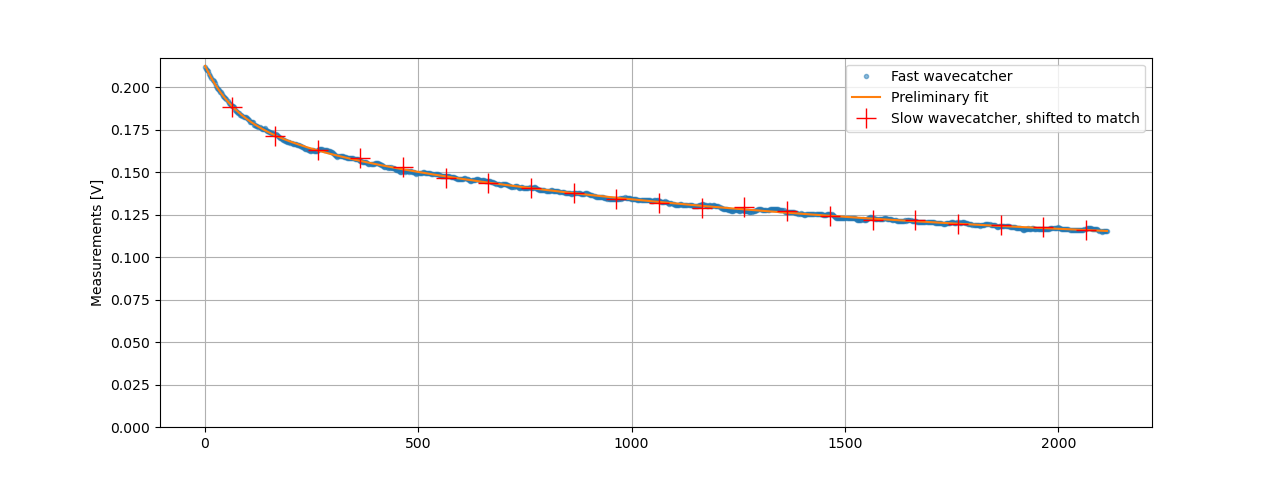

In [11]:


fit_params, pconv = get_fit_params(data_fast_aligned["time_fit"], data_fast_aligned["ch3_fit"])

plt.figure(figsize=(6.4*2, 4.8))

plt.plot(data_fast_aligned["time_fit"], data_fast_aligned["ch3_fit"], ".", label = "Fast wavecatcher", alpha = 0.5)

plt.plot(data_fast_aligned["time_fit"], fitFunc(data_fast_aligned["time_fit"], **fit_params), label = "Preliminary fit")


catcher_shift = lambda x, sh: fitFunc(x-sh, **fit_params)

shift, _ = curve_fit(catcher_shift, data_slow_aligned["time_fit"][:21], data_slow_aligned["ch3_fit"][:21], p0=[30])
shift = shift[0]

print("The shift besween to data samples is", shift, "nanoseconds")


plt.plot(data_slow_aligned["time_fit"][:21]-shift, data_slow_aligned["ch3_fit"][:21], "r+", markersize=14, label = "Slow wavecatcher, shifted to match")
plt.ylabel("Measurements [V]")
plt.ylim(0, None)
plt.grid()
plt.legend()



## ##### ##### ##### ##### ##### ##### #####
## align times of the slow wavecatcher
## ##### ##### ##### ##### ##### ##### #####

data_slow_aligned["time_fit"] -= shift


# Fitting of merged fase and slow readings

In [12]:
## ##### ##### ##### ### #
## merge readings  ##### #
## ##### ##### ##### ### #

times_merged = np.concatenate([data_fast_aligned["time_fit"], data_slow_aligned["time_fit"]], axis=0)
ch3_merged = np.concatenate([data_fast_aligned["ch3_fit"], data_slow_aligned["ch3_fit"]], axis=0)

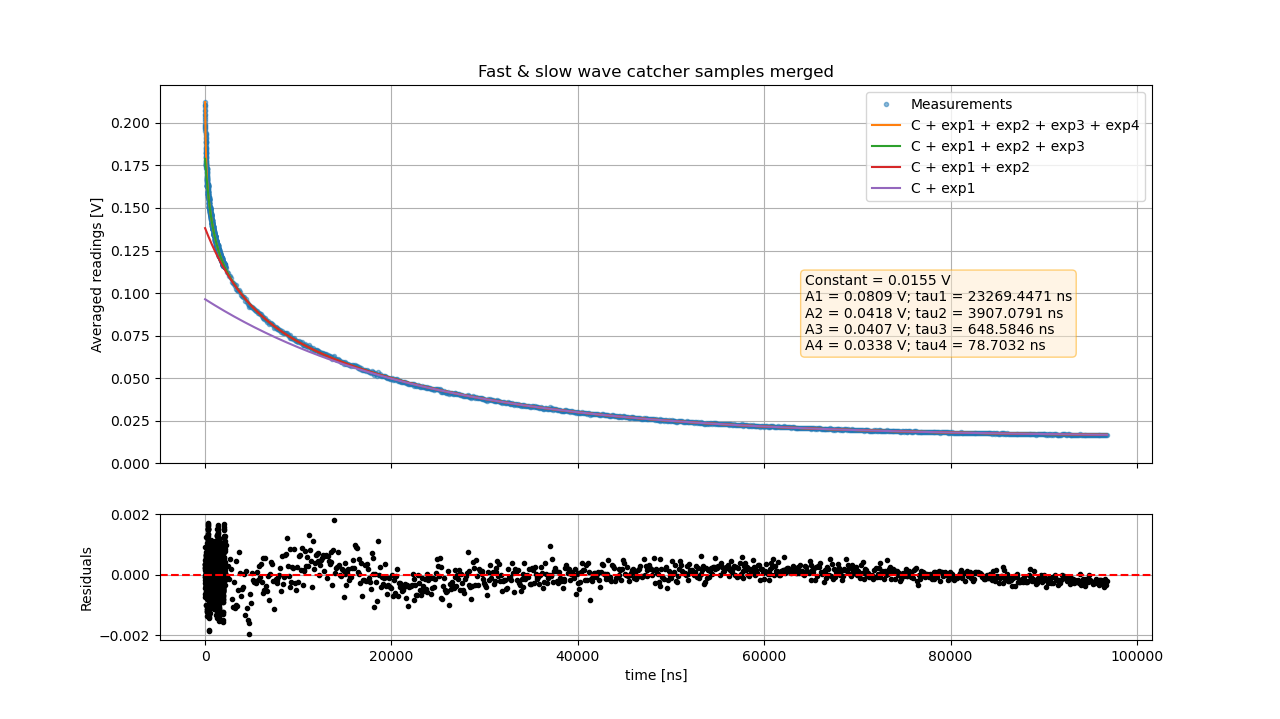

In [13]:
fig,(axm, axe) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6.4*2,4.8*1.5))


#############################################
## Perform fitting and draw it on the plot ##
#############################################

times_plot = np.linspace(np.min(times_merged), np.max(times_merged), int((np.max(times_merged) - np.min(times_merged))/data_fast["sample_rate"]))

fit_params, pconv = get_fit_params(times_merged, ch3_merged)

axm.plot(times_merged, ch3_merged, ".", label = "Measurements", alpha = 0.5)

axm.plot(times_plot, fitFunc(times_plot, **fit_params), label = "C + exp1 + exp2 + exp3 + exp4")

A0, A1, A2, A3, A4, L1, L2, L3, L4 = fit_params.values()

exp123 = lambda t: A0 + A1*np.exp(-L1*t) + A2*np.exp(-L2*t) + A3*np.exp(-L3*t)
axm.plot(times_plot, exp123(times_plot), label="C + exp1 + exp2 + exp3")

exp12 = lambda t: A0 + A1*np.exp(-L1*t) + A2*np.exp(-L2*t)
axm.plot(times_plot, exp12(times_plot), label="C + exp1 + exp2")

exp1 = lambda t: A0 + A1*np.exp(-L1*t)
axm.plot(times_plot, exp1(times_plot), label="C + exp1")

axm.set_ylabel("Averaged readings [V]")
axm.set_ylim(0, None)
axm.grid()
axm.legend()
axm.set_title("Fast & slow wave catcher samples merged")


bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
axm.text( 0.65, 0.3,
         "Constant = {:.4f} V\n".format(fit_params["A0"])+\
         "A1 = {:.4f} V; tau1 = {:.4f} ns\n".format(fit_params["A1"], 1/fit_params["L1"])+\
         "A2 = {:.4f} V; tau2 = {:.4f} ns\n".format(fit_params["A2"], 1/fit_params["L2"])+\
         "A3 = {:.4f} V; tau3 = {:.4f} ns\n".format(fit_params["A3"], 1/fit_params["L3"])+\
         "A4 = {:.4f} V; tau4 = {:.4f} ns  ".format(fit_params["A4"], 1/fit_params["L4"]),      
         transform = axm.transAxes, bbox=bbox)


#########################################################
## Perform estimation and draw of the uncertainty bars ##
#########################################################

# # Compute uncertainty in fit
# num_samples = 10000  # Number of Monte Carlo samples for uncertainty estimation
# param_samples = np.random.multivariate_normal(list(fit_params.values()), pconv, size=num_samples)

# y_fits = np.array([fitFunc(times_merged, *p) for p in param_samples])
# y_fit_mean = np.mean(y_fits, axis=0)
# y_fit_std = np.std(y_fits, axis=0)

residuals = ch3_merged - fitFunc(times_merged, **fit_params)

# Plot the residuals with error bars
axe.plot(times_merged, residuals, ".k")
axe.axhline(0, color="red", linestyle="--")
# axe.fill_between(times_merged, -2 * y_fit_std, 2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

# axm.fill_between(times_merged, y_fit_mean-2 * y_fit_std, y_fit_mean+2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

axe.set_ylabel("Residuals")
axe.set_xlabel("time [ns]")
# axe.legend()
axe.grid()


In [14]:
# plt.plot(data_fast_aligned["time_fit"], data_fast_aligned["ch3_fit"], ".", label = "Fast wavecatcher", alpha = 0.5)

# plt.plot(data_fast_aligned["time_fit"], fitFunc(data_fast_aligned["time_fit"], **fit_params), label = "Preliminary fit")


# catcher_shift = lambda x, sh: fitFunc(x-sh, **fit_params)

# shift, _ = curve_fit(catcher_shift, data_slow_aligned["time_fit"][:21], data_slow_aligned["ch3_fit"][:21], p0=[30])
# shift = shift[0]

# print("The shift besween to data samples is", shift, "nanoseconds")


# plt.plot(data_slow_aligned["time_fit"][:21]-shift, data_slow_aligned["ch3_fit"][:21], "r+", markersize=14, label = "Slow wavecatcher, shifted to match")


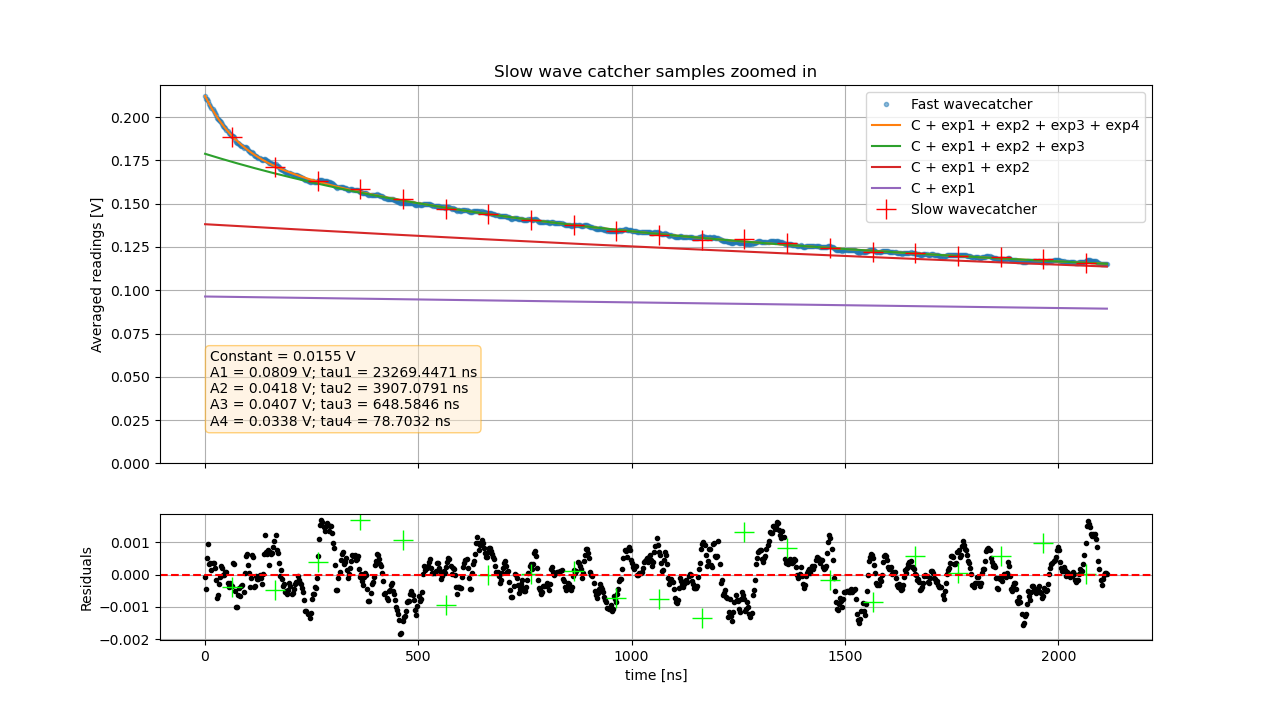

In [15]:
fig,(axm, axe) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6.4*2,4.8*1.5))

times_fast = data_fast_aligned["time_fit"]
ch3_fast = data_fast_aligned["ch3_fit"]

times_slow = data_slow_aligned["time_fit"][:21]
ch3_slow = data_slow_aligned["ch3_fit"][:21]

#############################################
## Perform fitting and draw it on the plot ##
#############################################

times_plot = np.linspace(np.min(times_fast), np.max(times_fast), int((np.max(times_fast) - np.min(times_fast))/data_fast["sample_rate"]))



axm.plot(times_fast, ch3_fast, ".", label = "Fast wavecatcher", alpha = 0.5)


axm.plot(times_plot, fitFunc(times_plot, **fit_params), label = "C + exp1 + exp2 + exp3 + exp4")

A0, A1, A2, A3, A4, L1, L2, L3, L4 = fit_params.values()

exp123 = lambda t: A0 + A1*np.exp(-L1*t) + A2*np.exp(-L2*t) + A3*np.exp(-L3*t)
axm.plot(times_plot, exp123(times_plot), label="C + exp1 + exp2 + exp3")

exp12 = lambda t: A0 + A1*np.exp(-L1*t) + A2*np.exp(-L2*t)
axm.plot(times_plot, exp12(times_plot), label="C + exp1 + exp2")

exp1 = lambda t: A0 + A1*np.exp(-L1*t)
axm.plot(times_plot, exp1(times_plot), label="C + exp1")

axm.plot(times_slow, ch3_slow, "+", markersize=14, label = "Slow wavecatcher", color="red")

axm.set_ylabel("Averaged readings [V]")
axm.set_ylim(0, None)
axm.grid()
axm.legend()
axm.set_title("Slow wave catcher samples zoomed in")


bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
axm.text( 0.05, 0.1,
         "Constant = {:.4f} V\n".format(fit_params["A0"])+\
         "A1 = {:.4f} V; tau1 = {:.4f} ns\n".format(fit_params["A1"], 1/fit_params["L1"])+\
         "A2 = {:.4f} V; tau2 = {:.4f} ns\n".format(fit_params["A2"], 1/fit_params["L2"])+\
         "A3 = {:.4f} V; tau3 = {:.4f} ns\n".format(fit_params["A3"], 1/fit_params["L3"])+\
         "A4 = {:.4f} V; tau4 = {:.4f} ns  ".format(fit_params["A4"], 1/fit_params["L4"]),      
         transform = axm.transAxes, bbox=bbox)


#########################################################
## Perform estimation and draw of the uncertainty bars ##
#########################################################

# # Compute uncertainty in fit
# num_samples = 10000  # Number of Monte Carlo samples for uncertainty estimation
# param_samples = np.random.multivariate_normal(list(fit_params.values()), pconv, size=num_samples)

# y_fits = np.array([fitFunc(times_fast, *p) for p in param_samples])
# y_fit_mean = np.mean(y_fits, axis=0)
# y_fit_std = np.std(y_fits, axis=0)

residuals = ch3_fast - fitFunc(times_fast, **fit_params)

residuals_slow = ch3_slow - fitFunc(times_slow, **fit_params)

# Plot the residuals with error bars
axe.plot(times_fast, residuals, ".k")
axe.plot(times_slow, residuals_slow, "+", color="lime", markersize = 14)
axe.axhline(0, color="red", linestyle="--")
# axe.fill_between(times_fast, -2 * y_fit_std, 2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

# axm.fill_between(times_fast, y_fit_mean-2 * y_fit_std, y_fit_mean+2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

axe.set_ylabel("Residuals")
axe.set_xlabel("time [ns]")
# axe.legend()
axe.grid()